In [29]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.py'>

In [30]:
ntuples = '20170509'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
diphotonJets = [s for s in files if "DiPhotonJets" in s]
gJets = [s for s in files if "GJet" in s]

utils.IO.add_signal(ntuples,signal)
utils.IO.add_background(ntuples,diphotonJets)
utils.IO.add_background(ntuples,gJets)
for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509
using background file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_GJet_total.root
using signal file n.0: /mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root


In [31]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd


#FIXME, read weights from json file
utils.IO.w_sig.append(1)
utils.IO.w_bkg.append(0.5)
utils.IO.w_bkg.append(2.5)

utils.preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,X_sig,y_sig=utils.preprocessing.set_variables(branch_names)

print X_bkg

X_bkg,y_bkg,utils.IO.weights_bkg = utils.preprocessing.randomize(X_bkg,y_bkg,utils.IO.weights_bkg)
X_sig,y_sig,utils.IO.weights_sig = utils.preprocessing.randomize(X_sig,y_sig,utils.IO.weights_sig)


y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = utils.preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = utils.preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = utils.preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = utils.preprocessing.get_total_training_sample(utils.IO.weights_sig,utils.IO.weights_bkg).ravel()
w_total_test = utils.preprocessing.get_total_test_sample(utils.IO.weights_sig,utils.IO.weights_bkg).ravel()

['leadingJet_bDis', 'subleadingJet_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M()', 'noexpand:dijetCandidate.Pt()/diHiggsCandidate.M()']
[[ 0.72155041  0.52785558  0.42634881 ...,  0.70304108  0.19026322
   0.28491264]
 [ 0.41179019  0.13304248  0.56226218 ...,  0.48191923  0.31700848
   0.58766929]
 [ 0.83717602  0.17259908  0.75705594 ...,  0.82221067  0.35188219
   0.14440304]
 ..., 
 [ 0.34270886  0.2988658   0.94195563 ...,  0.70651877  0.14593959
   0.11432408]
 [ 0.15307848  0.25315225  0.92755836 ...,  0.23098993  0.15243959
   0.07660141]
 [ 0.19205889  0.16505937  0.86369425 ...,  0.62184268  0.23574548
   0.09499818]]


In [ ]:
import xgboost as xgb
#####FIXME!!!!!just for speed test, reset parameters
clf = xgb.XGBClassifier(max_depth=10,learning_rate=0.2,n_estimators=500, min_child_weight=1e-5, nthread= 12)
#clf = ensemble.GradientBoostingClassifier(max_depth=10,learning_rate=0.1,n_estimators=200,verbose=1)
clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)

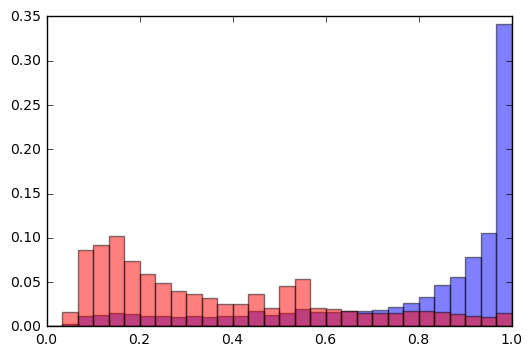

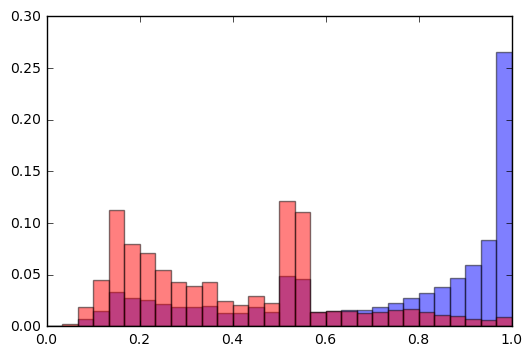

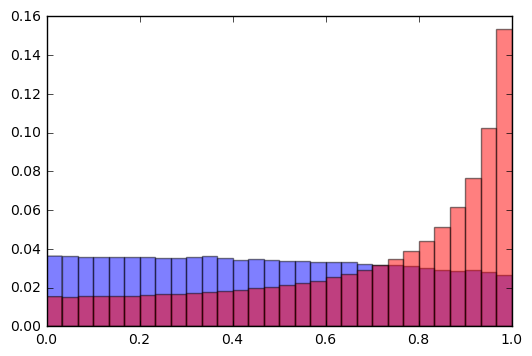

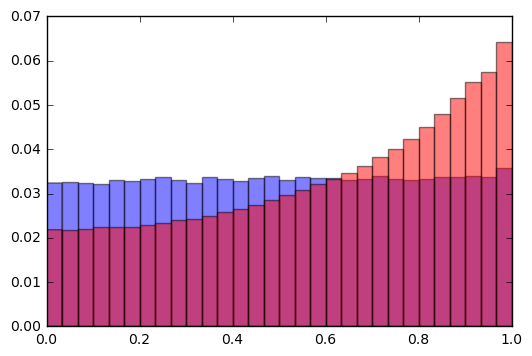

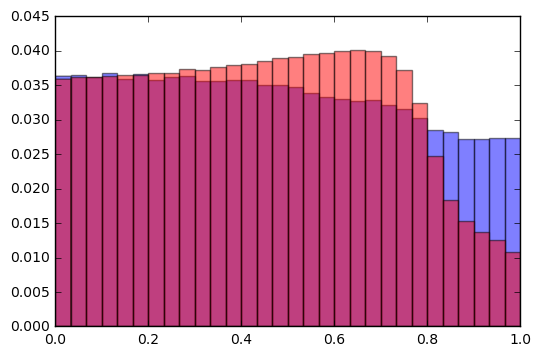

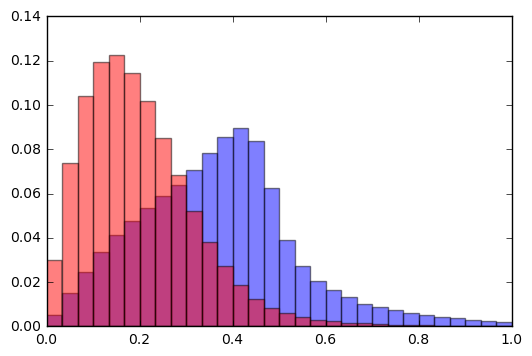

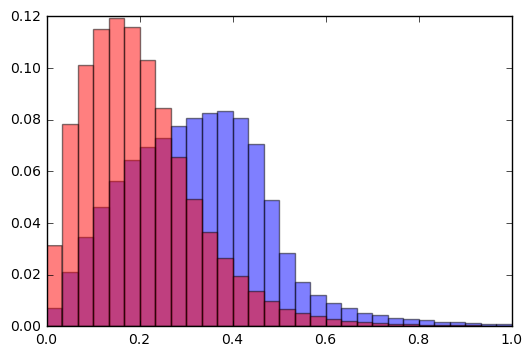

In [205]:
#FIXME, do weighted plots?
utils.plotting.plot_input_variables(X_sig,X_bkg)

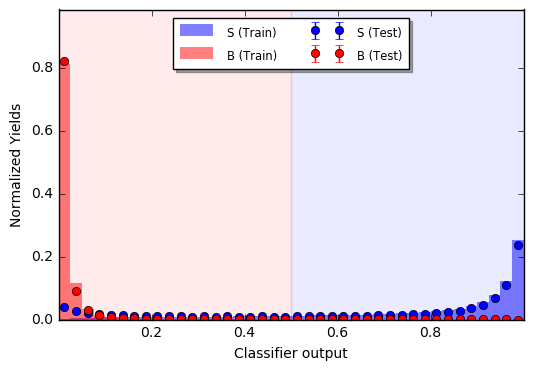

In [60]:
import matplotlib.pyplot as plt

X_total_test = utils.preprocessing.get_total_test_sample(X_sig),X_bkg))
y_total_test = utils.preprocessing.get_total_test_sample(y_sig),y_bkg)).ravel()

utils.plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg")
plt.show()

In [51]:
bkg_train = X_total_train[y_total_train == -1]
print clf.predict_proba(bkg_train)[:,0] 
print clf.predict_proba(bkg_train)[:,1] 
print clf.predict_proba(bkg_train)[:,2] 

[ 0.00197843  0.05096103  0.02407886 ...,  0.00485183  0.00593206
  0.01907289]
[ 0.99677533  0.9338457   0.95034254 ...,  0.79748398  0.47218218
  0.96558708]
[ 0.00124624  0.01519331  0.02557863 ...,  0.1976642   0.52188575
  0.01534001]


In [59]:
bkg_train = X_total_train[y_total_train == -1]
print clf.predict_proba(bkg_train)[:,0] 
print clf.predict_proba(bkg_train)[:,1] 
print clf.predict_proba(bkg_train)[:,2] 

[ 0.055061    0.12778421  0.05098724 ...,  0.00015427  0.11611697
  0.00027659]
[ 0.78416479  0.87200946  0.9331829  ...,  0.91216987  0.87193131
  0.59956926]
[  1.60774276e-01   2.06298049e-04   1.58298314e-02 ...,   8.76758471e-02
   1.19517483e-02   4.00154203e-01]


In [52]:
bkg_train = X_total_train[y_total_train == -2]
print clf.predict_proba(bkg_train)[:,0] 
print clf.predict_proba(bkg_train)[:,1] 
print clf.predict_proba(bkg_train)[:,2] 

[ 0.18127121  0.11614756  0.1507366  ...,  0.19727221  0.58986998
  0.21564847]
[ 0.81389666  0.88246191  0.8482157  ...,  0.79742825  0.40997869
  0.78361613]
[ 0.00483213  0.00139051  0.00104769 ...,  0.0052995   0.00015136
  0.00073547]


[ 0.56439251  0.36454788  0.65392524 ...,  0.10267255  0.51955968
  0.16224623]


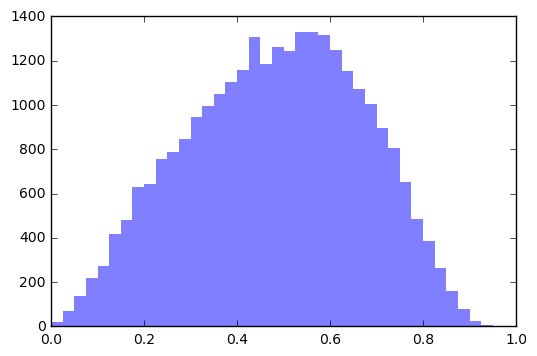

In [61]:
bkg_train = X_total_train[y_total_train == -2]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

[ 0.78416479  0.87200946  0.9331829  ...,  0.91216987  0.87193131
  0.59956926]


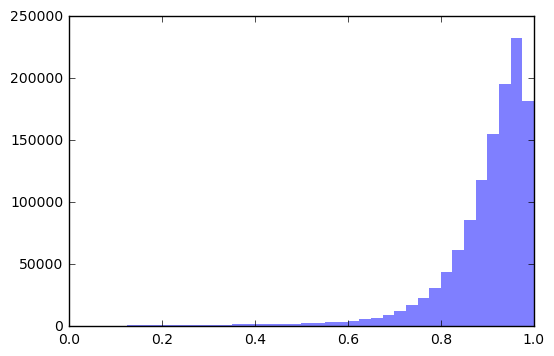

In [62]:
bkg_train = X_total_train[y_total_train == -1]
print clf.predict_proba(bkg_train)[:,1] 
Y_pred_bkg_train = clf.predict_proba(bkg_train)[:,1]

Histo_training_S = np.histogram(Y_pred_bkg_train,bins=40,range=(0,1))
ax1 = plt.subplot(111)

bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])


ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
plt.show()

In [38]:
X = np.array([[1., 0.], [2., 1.], [0., 0.]])
y = np.array([0, 1, 2])
print X
print y
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]
print X
print y

[[ 1.  0.]
 [ 2.  1.]
 [ 0.  0.]]
[0 1 2]
[[ 0.  0.]
 [ 2.  1.]
 [ 1.  0.]]
[2 1 0]


In [26]:
reload(utils)
utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
print utils.IO.get_weight('signal','nrSM',0)
print utils.IO.get_weight('background','GJets',0)
print utils.IO.get_weight('background','GJets',1)

1e-05
3.58135559049e-05
0.000218090298107
